## Caution: important experiment, please do not adjust

The contents within this file are for running a publication-quality experiment and producing the associated figures and results. As such, it is finely tuned for specific high-quality graphics using the `primary.mplstyle` file. Please do not adjust. If you need to replicate results on your local system, please create a new notebook and copy contents from here.

In [1]:
import sys
sys.path.append('../..')  # Expose top level program access

import re
import time
import pickle
import logging
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from sklearn.covariance import EllipticEnvelope
from mpl_toolkits.mplot3d import Axes3D
from functools import reduce
from pathlib import Path
from utils import tools, metrics, supported_preprocessing_transforms
from modules.aae_base_module import AAEBaseModule
from modules.vae_base_module import VAEBaseModule
from models import supported_models
from datasets import supported_datamodules
from scipy.stats import gaussian_kde
from utils.dtypes import *

logging.getLogger("matplotlib").setLevel(logging.WARNING)  # Suppress verbose font warnings from matplotlib

In [2]:
# import configurations and paths to logged models
root = Path.cwd().parents[1]
log_path = root / 'logs' / 'CuriosityDataModule'
paths_to_archived_models = list(Path(log_path).glob('**/archive_v*'))

# filter the models that don't provide structured latent representations
for i, p in enumerate(paths_to_archived_models.copy()):
    if not re.search('VAE|AAE', str(p)):
        paths_to_archived_models.remove(p)

print('Found archived models:\n------')
print('\n'.join([f'{p.parent.name}/{p.name}' for p in paths_to_archived_models]))

Found archived models:
------
SimpleVAE/archive_v1_2021-04-23
SimpleAAE/archive_v3_2021-05-19
BaselineVAE/archive_v1_2021-04-23
BaselineAAE/archive_v2_2021-05-08


In [3]:
def load_modules(paths_to_archived_models: List[Path]) -> dict:
    # Load the checkpoints for all the training modules and save them in a dictionary
    module_catalog = {}

    for pth in paths_to_archived_models:

        model_type = pth.parent.name
        model_name = pth.name
        config = tools.load_config(pth / 'configuration.yaml', silent=True)
        print(f'Loading state dict for: {model_type}/{model_name}')

        # Unsupervising region proposal is called implicity in this line, see utils/preprocessing.py
        preprocessing_transforms = supported_preprocessing_transforms[config['data-parameters']['preprocessing']]

        datamodule = supported_datamodules[config['experiment-parameters']['datamodule']](
            data_transforms=preprocessing_transforms,
            **config['data-parameters'])

        if 'PCA' in model_type:

            _, pca_test_labels = datamodule.split(train=False)

            with open(pth / 'fitted_model.p', 'rb') as f:
                model = pickle.load(f)
                module = PCABaseModule(model)
        else:
            ckpt_path = next(iter((pth / 'checkpoints').glob('val_*')))

            datamodule.setup('test')

            # Handle the various model instantiations
            if 'AAE' in model_type:
                model = supported_models[model_type](
                    in_shape=datamodule.data_shape,
                    latent_nodes=config['module-parameters']['latent_nodes'])
                module = AAEBaseModule(model, **config['module-parameters'])
            elif 'VAE' in model_type:
                model = supported_models[model_type](
                    in_shape=datamodule.data_shape,
                    latent_nodes=config['module-parameters']['latent_nodes'])
                module = VAEBaseModule(model, **config['module-parameters'])
            elif 'CAE' in model_type:
                model = supported_models[model_type](in_shape=datamodule.data_shape)
                module = CAEBaseModule(model, **config['module-parameters'])
            else:
                raise ValueError(f'Model substring not found, got {model_type}')

            # Load the state_dict into the module architecture
            checkpoint = torch.load(ckpt_path)
            module.load_state_dict(checkpoint['state_dict'])

        if model_type not in module_catalog:
            module_catalog[model_type] = {}
        module_catalog[model_type][model_name] = module
        
    if 'pca_test_labels' in locals():
        return module_catalog, datamodule, pca_test_labels
    return module_catalog, datamodule, -1
        
module_catalog, datamodule, _ = load_modules(paths_to_archived_models)

Loading state dict for: SimpleVAE/archive_v1_2021-04-23
Loading state dict for: SimpleAAE/archive_v3_2021-05-19
Loading state dict for: BaselineVAE/archive_v1_2021-04-23
Loading state dict for: BaselineAAE/archive_v2_2021-05-08


In [4]:
# Collect scores and labels on test set for all models and save to a dictionary
result_catalog = {}

for model_type, model_variants in module_catalog.items():
    start_time = time.time()
    
    for model_name, module in model_variants.items():
        
        latent_vecs = []
        test_novelty_scores = []
        test_novelty_labels = []
        short_name = model_type + '-' + model_name.split('_')[1]
        print(f'------\n{short_name}\n------')
        
        if short_name not in result_catalog:
            result_catalog[short_name] = {
                'latent_vecs': [],
                'scores':      [], 
                'labels':      []
            }
        
        # Set the model/components to evaluation mode
        if 'AAE' in model_type:
            module.encoder.eval()
            module.decoder.eval()
        else:
            module.model.eval()

        with torch.no_grad():
            for batch_nb, batch in enumerate(datamodule.test_dataloader()):

                result = module.test_step(batch, batch_nb)
                
                # Populate results
                latent_vecs.extend(result['images']['batch_lt'].cpu().numpy())
                test_novelty_scores.extend(result['scores'])
                test_novelty_labels.extend(result['labels'].cpu().numpy())                
                print(f'[BATCH {batch_nb}] Mean score: {np.mean(result["scores"])}')
                    
        result_catalog[short_name]['latent_vecs'] = latent_vecs
        result_catalog[short_name]['scores'] = test_novelty_scores
        result_catalog[short_name]['labels'] = test_novelty_labels
        print(f'{short_name} Time: {time.time() - start_time:.2f} s\n')

------
SimpleVAE-v1
------
[BATCH 0] Mean score: 0.639762282371521
[BATCH 1] Mean score: 0.6762609481811523
[BATCH 2] Mean score: 0.8170021772384644
[BATCH 3] Mean score: 0.7925180792808533
SimpleVAE-v1 Time: 1.01 s

------
SimpleAAE-v3
------
[BATCH 0] Mean score: 0.8250387907028198
[BATCH 1] Mean score: 0.8286464214324951
[BATCH 2] Mean score: 0.8829889297485352
[BATCH 3] Mean score: 0.8692642450332642
SimpleAAE-v3 Time: 0.70 s

------
BaselineVAE-v1
------
[BATCH 0] Mean score: 0.6412885785102844
[BATCH 1] Mean score: 0.6745316982269287
[BATCH 2] Mean score: 0.8116108179092407
[BATCH 3] Mean score: 0.777187168598175
BaselineVAE-v1 Time: 8.42 s

------
BaselineAAE-v2
------
[BATCH 0] Mean score: 0.6298120617866516
[BATCH 1] Mean score: 0.6476290225982666
[BATCH 2] Mean score: 0.7605627775192261
[BATCH 3] Mean score: 0.7350038886070251
BaselineAAE-v2 Time: 9.27 s



In [15]:
ds = sns.load_dataset('penguins')
print(ds.head())

  species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen            39.1           18.7              181.0   
1  Adelie  Torgersen            39.5           17.4              186.0   
2  Adelie  Torgersen            40.3           18.0              195.0   
3  Adelie  Torgersen             NaN            NaN                NaN   
4  Adelie  Torgersen            36.7           19.3              193.0   

   body_mass_g     sex  
0       3750.0    Male  
1       3800.0  Female  
2       3250.0  Female  
3          NaN     NaN  
4       3450.0  Female  


2021-05-21 08:29:20,013 - WARNING - findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
2021-05-21 08:29:21,049 - DEBUG - STREAM b'IHDR' 16 13
2021-05-21 08:29:21,050 - DEBUG - STREAM b'PLTE' 41 48
2021-05-21 08:29:21,050 - DEBUG - STREAM b'tRNS' 101 15
2021-05-21 08:29:21,050 - DEBUG - STREAM b'pHYs' 128 9
2021-05-21 08:29:21,051 - DEBUG - STREAM b'IDAT' 149 76
2021-05-21 08:29:21,053 - DEBUG - STREAM b'IHDR' 16 13
2021-05-21 08:29:21,053 - DEBUG - STREAM b'PLTE' 41 48
2021-05-21 08:29:21,054 - DEBUG - STREAM b'tRNS' 101 15
2021-05-21 08:29:21,054 - DEBUG - STREAM b'pHYs' 128 9
2021-05-21 08:29:21,055 - DEBUG - STREAM b'IDAT' 149 74
2021-05-21 08:29:21,057 - DEBUG - STREAM b'IHDR' 16 13
2021-05-21 08:29:21,057 - DEBUG - STREAM b'PLTE' 41 39
2021-05-21 08:29:21,058 - DEBUG - STREAM b'tRNS' 92 12
2021-05-21 08:29:21,058 - DEBUG - STREAM b'pHYs' 116 9
2021-05-21 08:29:21,058 - DEBUG - STREAM b'IDAT' 137 43
2021-05-21 08:29:21,060 - DEBUG - STREAM b'IHDR' 16 13
2021-05

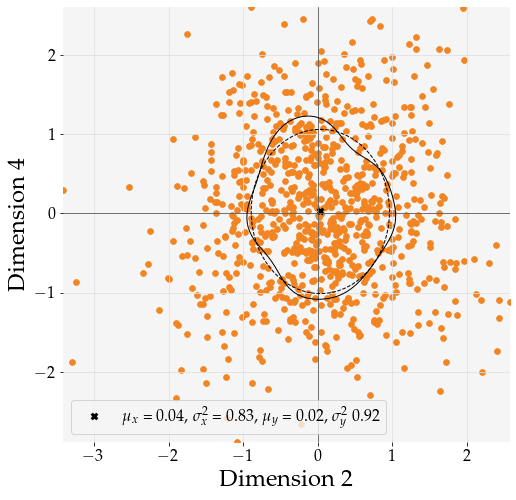

2021-05-21 08:29:21,598 - DEBUG - STREAM b'IHDR' 16 13
2021-05-21 08:29:21,599 - DEBUG - STREAM b'PLTE' 41 48
2021-05-21 08:29:21,599 - DEBUG - STREAM b'tRNS' 101 15
2021-05-21 08:29:21,600 - DEBUG - STREAM b'pHYs' 128 9
2021-05-21 08:29:21,600 - DEBUG - STREAM b'IDAT' 149 181
2021-05-21 08:29:21,610 - DEBUG - STREAM b'IHDR' 16 13
2021-05-21 08:29:21,611 - DEBUG - STREAM b'PLTE' 41 48
2021-05-21 08:29:21,611 - DEBUG - STREAM b'tRNS' 101 15
2021-05-21 08:29:21,611 - DEBUG - STREAM b'pHYs' 128 9
2021-05-21 08:29:21,612 - DEBUG - STREAM b'IDAT' 149 181
2021-05-21 08:29:21,613 - DEBUG - STREAM b'IHDR' 16 13
2021-05-21 08:29:21,614 - DEBUG - STREAM b'PLTE' 41 48
2021-05-21 08:29:21,614 - DEBUG - STREAM b'tRNS' 101 15
2021-05-21 08:29:21,614 - DEBUG - STREAM b'pHYs' 128 9
2021-05-21 08:29:21,614 - DEBUG - STREAM b'IDAT' 149 157
2021-05-21 08:29:21,616 - DEBUG - STREAM b'IHDR' 16 13
2021-05-21 08:29:21,616 - DEBUG - STREAM b'PLTE' 41 48
2021-05-21 08:29:21,617 - DEBUG - STREAM b'tRNS' 101 15


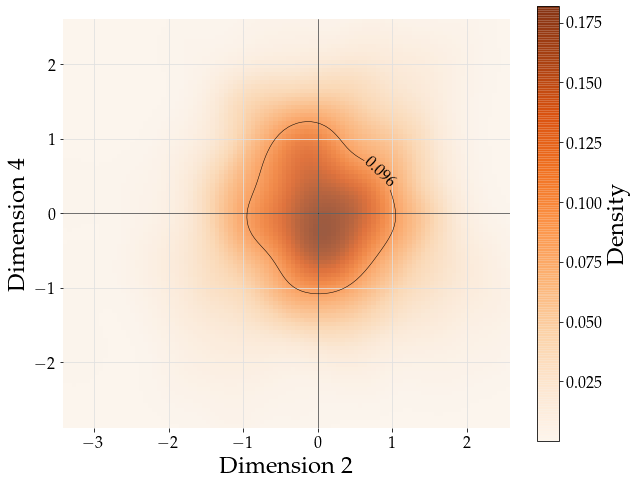

2021-05-21 08:29:22,103 - DEBUG - STREAM b'IHDR' 16 13
2021-05-21 08:29:22,104 - DEBUG - STREAM b'PLTE' 41 48
2021-05-21 08:29:22,104 - DEBUG - STREAM b'tRNS' 101 15
2021-05-21 08:29:22,105 - DEBUG - STREAM b'pHYs' 128 9
2021-05-21 08:29:22,105 - DEBUG - STREAM b'IDAT' 149 63
2021-05-21 08:29:22,116 - DEBUG - STREAM b'IHDR' 16 13
2021-05-21 08:29:22,116 - DEBUG - STREAM b'PLTE' 41 45
2021-05-21 08:29:22,117 - DEBUG - STREAM b'tRNS' 98 14
2021-05-21 08:29:22,117 - DEBUG - STREAM b'pHYs' 124 9
2021-05-21 08:29:22,117 - DEBUG - STREAM b'IDAT' 145 66
2021-05-21 08:29:22,140 - DEBUG - STREAM b'IHDR' 16 13
2021-05-21 08:29:22,141 - DEBUG - STREAM b'PLTE' 41 48
2021-05-21 08:29:22,141 - DEBUG - STREAM b'tRNS' 101 15
2021-05-21 08:29:22,141 - DEBUG - STREAM b'pHYs' 128 9
2021-05-21 08:29:22,141 - DEBUG - STREAM b'IDAT' 149 986


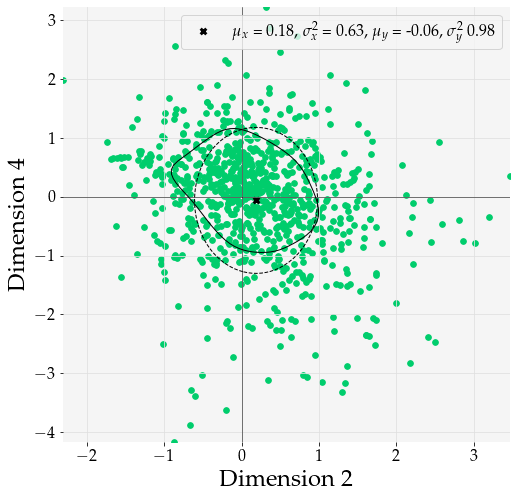

2021-05-21 08:29:22,504 - DEBUG - STREAM b'IHDR' 16 13
2021-05-21 08:29:22,505 - DEBUG - STREAM b'PLTE' 41 48
2021-05-21 08:29:22,505 - DEBUG - STREAM b'tRNS' 101 15
2021-05-21 08:29:22,506 - DEBUG - STREAM b'pHYs' 128 9
2021-05-21 08:29:22,506 - DEBUG - STREAM b'IDAT' 149 166
2021-05-21 08:29:22,515 - DEBUG - STREAM b'IHDR' 16 13
2021-05-21 08:29:22,515 - DEBUG - STREAM b'PLTE' 41 48
2021-05-21 08:29:22,515 - DEBUG - STREAM b'tRNS' 101 15
2021-05-21 08:29:22,516 - DEBUG - STREAM b'pHYs' 128 9
2021-05-21 08:29:22,516 - DEBUG - STREAM b'IDAT' 149 111
2021-05-21 08:29:22,518 - DEBUG - STREAM b'IHDR' 16 13
2021-05-21 08:29:22,518 - DEBUG - STREAM b'PLTE' 41 48
2021-05-21 08:29:22,518 - DEBUG - STREAM b'tRNS' 101 15
2021-05-21 08:29:22,518 - DEBUG - STREAM b'pHYs' 128 9
2021-05-21 08:29:22,519 - DEBUG - STREAM b'IDAT' 149 139
2021-05-21 08:29:22,521 - DEBUG - STREAM b'IHDR' 16 13
2021-05-21 08:29:22,521 - DEBUG - STREAM b'PLTE' 41 48
2021-05-21 08:29:22,521 - DEBUG - STREAM b'tRNS' 101 15


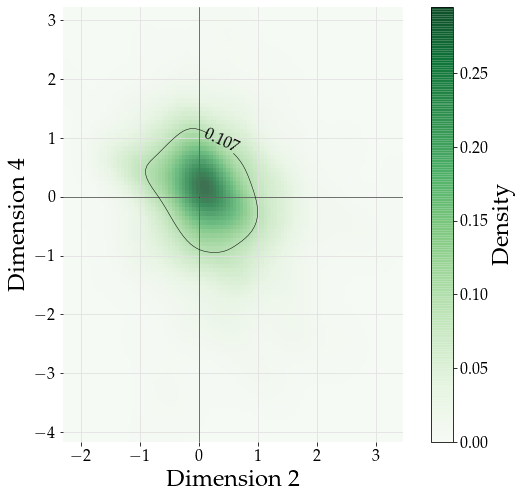

2021-05-21 08:29:23,158 - DEBUG - STREAM b'IHDR' 16 13
2021-05-21 08:29:23,159 - DEBUG - STREAM b'PLTE' 41 48
2021-05-21 08:29:23,160 - DEBUG - STREAM b'tRNS' 101 15
2021-05-21 08:29:23,160 - DEBUG - STREAM b'pHYs' 128 9
2021-05-21 08:29:23,160 - DEBUG - STREAM b'IDAT' 149 828


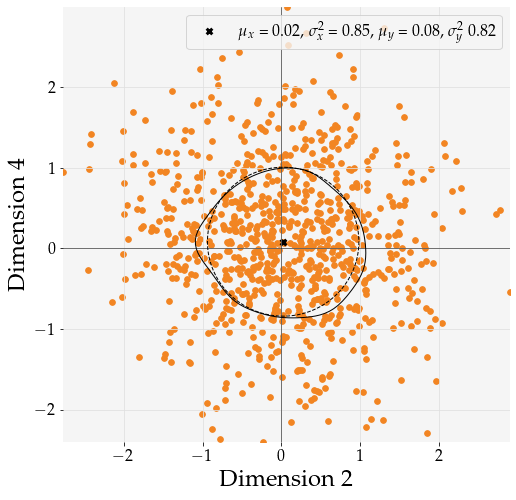

2021-05-21 08:29:23,658 - DEBUG - STREAM b'IHDR' 16 13
2021-05-21 08:29:23,659 - DEBUG - STREAM b'PLTE' 41 48
2021-05-21 08:29:23,659 - DEBUG - STREAM b'tRNS' 101 15
2021-05-21 08:29:23,660 - DEBUG - STREAM b'pHYs' 128 9
2021-05-21 08:29:23,660 - DEBUG - STREAM b'IDAT' 149 152


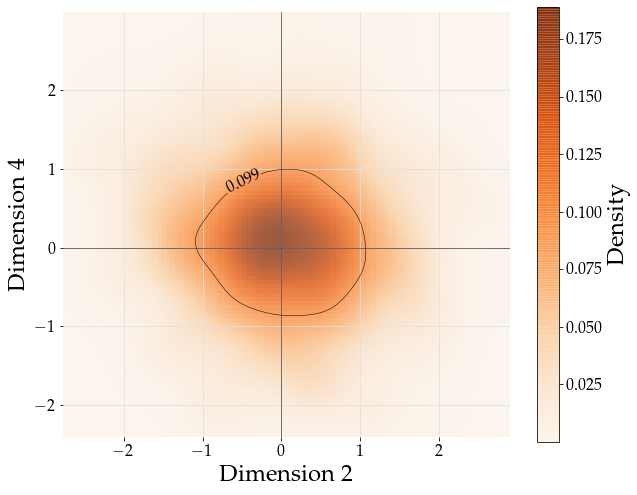

2021-05-21 08:29:24,170 - DEBUG - STREAM b'IHDR' 16 13
2021-05-21 08:29:24,171 - DEBUG - STREAM b'PLTE' 41 48
2021-05-21 08:29:24,171 - DEBUG - STREAM b'tRNS' 101 15
2021-05-21 08:29:24,171 - DEBUG - STREAM b'pHYs' 128 9
2021-05-21 08:29:24,172 - DEBUG - STREAM b'IDAT' 149 956


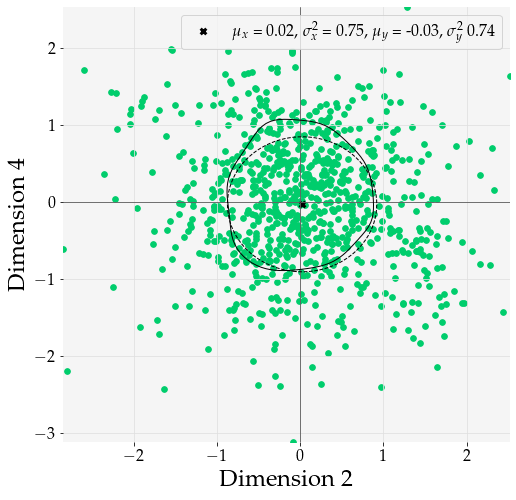

2021-05-21 08:29:24,527 - DEBUG - STREAM b'IHDR' 16 13
2021-05-21 08:29:24,527 - DEBUG - STREAM b'PLTE' 41 48
2021-05-21 08:29:24,528 - DEBUG - STREAM b'tRNS' 101 15
2021-05-21 08:29:24,528 - DEBUG - STREAM b'pHYs' 128 9
2021-05-21 08:29:24,528 - DEBUG - STREAM b'IDAT' 149 156
2021-05-21 08:29:24,546 - DEBUG - STREAM b'IHDR' 16 13
2021-05-21 08:29:24,547 - DEBUG - STREAM b'PLTE' 41 48
2021-05-21 08:29:24,547 - DEBUG - STREAM b'tRNS' 101 15
2021-05-21 08:29:24,547 - DEBUG - STREAM b'pHYs' 128 9
2021-05-21 08:29:24,548 - DEBUG - STREAM b'IDAT' 149 157


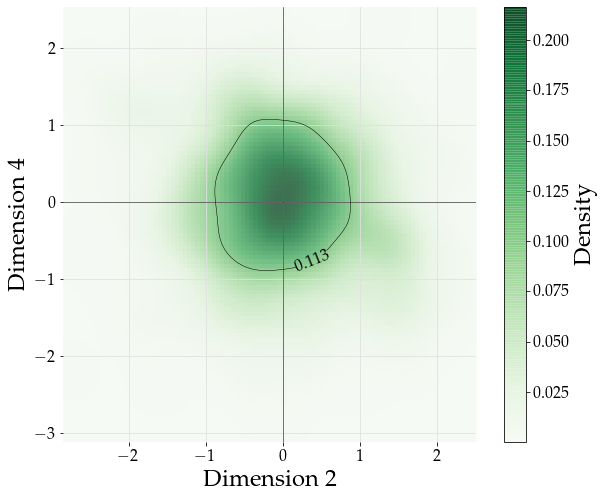

In [5]:
def gaussian2d(x, y, x_mu, x_var, y_mu, y_var):
    arg_x = (x - x_mu)**2 / (2*x_var**2)
    arg_y = (y - y_mu)**2 / (2*y_var**2)    
    return np.exp(-(arg_x + arg_y))

def fwhm(std):
    return 2*np.sqrt(2*np.log(2))*std

# Use standard custom styling
plt.style.use('../../utils/_extras/primary.mplstyle')

def latent_vis_2d(latent_vecs, dim_x: int = 2, dim_y: int = 4, save_name=None, color='C1', show_plots=True):

    # Code for setting up advanced plotting and graphing
    x_mean, x_var = latent_vecs[:, dim_x].mean(), latent_vecs[:, dim_x].var()
    y_mean, y_var = latent_vecs[:, dim_y].mean(), latent_vecs[:, dim_y].var()
    kde = gaussian_kde(latent_vecs[:, [dim_x, dim_y]].T)

    x_steps = np.linspace(latent_vecs[:, dim_x].min(), latent_vecs[:, dim_x].max(), 100)
    y_steps = np.linspace(latent_vecs[:, dim_y].min(), latent_vecs[:, dim_y].max(), 100)
    X, Y = np.meshgrid(x_steps, y_steps)
    Z = kde.evaluate(np.vstack([X.ravel(), Y.ravel()]))

    Zgaussian = gaussian2d(X, Y, x_mean, x_var, y_mean, y_var)

    
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.scatter(latent_vecs[:, dim_x], latent_vecs[:, dim_y], s=2**5, alpha=1., color=color)

    ax.contour(
        X, Y, Zgaussian, levels=[fwhm(Zgaussian.std())], 
        colors='k', linewidths=1., linestyles='--', alpha=1.0)
    ax.contour(
        X, Y, Z.reshape(X.shape), levels=[fwhm(Z.std())], 
        colors='k', linewidths=1., linestyles='-', alpha=1.0)

    ax.scatter([x_mean], [y_mean], color='k', marker='x', s=2**5, 
                label=r'$\mu_x$ = {:.2f}, $\sigma^2_x$ = {:.2f}, $\mu_y$ = {:.2f}, $\sigma^2_y$ {:.2f}'.format(x_mean, x_var, y_mean, y_var))

    ax.axhline(0, 0, c='k', lw=0.5)
    ax.axvline(0, 0, c='k', lw=0.5)
    ax.legend()
    ax.set_xlabel(f'Dimension {dim_x}')
    ax.set_ylabel(f'Dimension {dim_y}')

    if save_name is not None and isinstance(save_name, str):
        plt.savefig(f'LatentScatter-{save_name}.pdf', format='pdf',  bbox_inches='tight')
    plt.show()

    
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    cb = ax.imshow(Z.reshape(X.shape), cmap='Oranges' if color=='C6' else 'Greens', 
              extent=[x_steps[0], x_steps[-1], y_steps[0], y_steps[-1]], origin='lower', alpha=0.75)
    c = ax.contour(X, Y, Z.reshape(X.shape), colors='k', levels=[fwhm(Z.std())], linewidths=0.5)

    ax.axhline(0, 0, c='k', lw=0.5)
    ax.axvline(0, 0, c='k', lw=0.5)
    ax.set_xlabel(f'Dimension {dim_x}')
    ax.set_ylabel(f'Dimension {dim_y}')
    ax.clabel(c, fontsize=16)
    
    cb = fig.colorbar(cb)
    cb.set_label('Density')
    
    if save_name is not None and isinstance(save_name, str):
        plt.savefig(f'LatentKDE-{save_name}.pdf', format='pdf',  bbox_inches='tight')
    plt.show()
    
    
for sn, res in result_catalog.items():
    lt_vecs = np.stack(res['latent_vecs'], axis=0)
    color = 'C1' if 'AAE' in sn else 'C6'
    latent_vis_2d(lt_vecs, save_name=sn, color=color)

<Figure size 720x720 with 0 Axes>

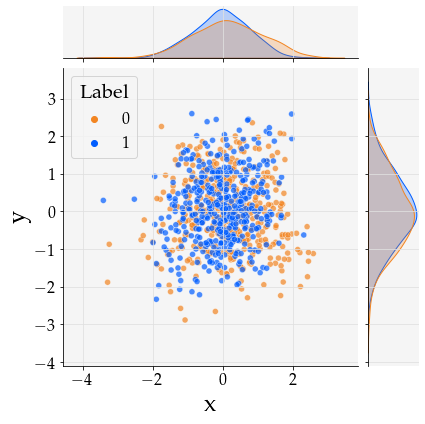

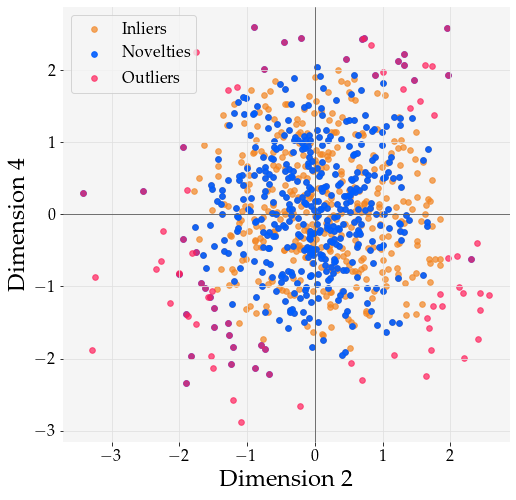

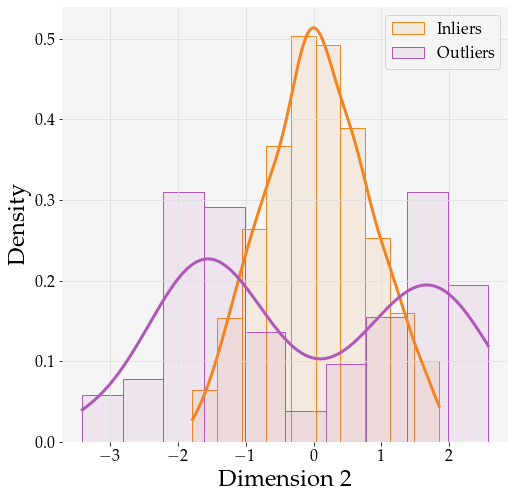

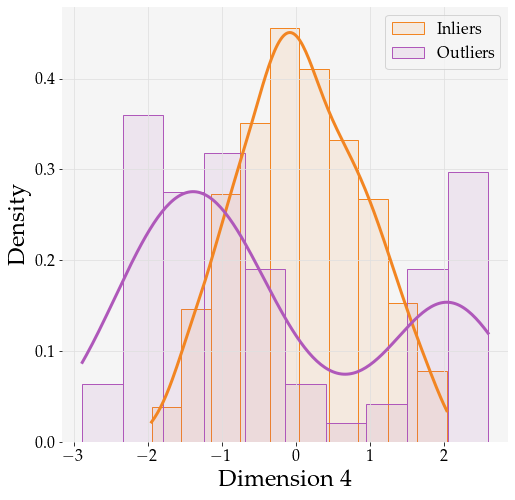

<Figure size 720x720 with 0 Axes>

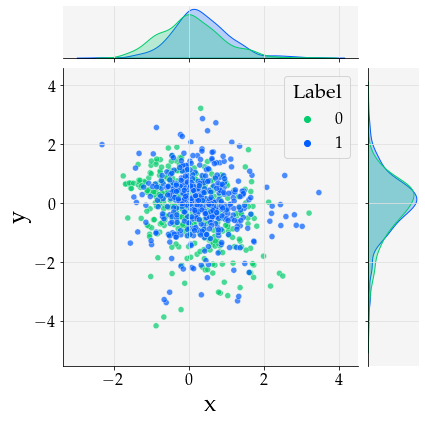

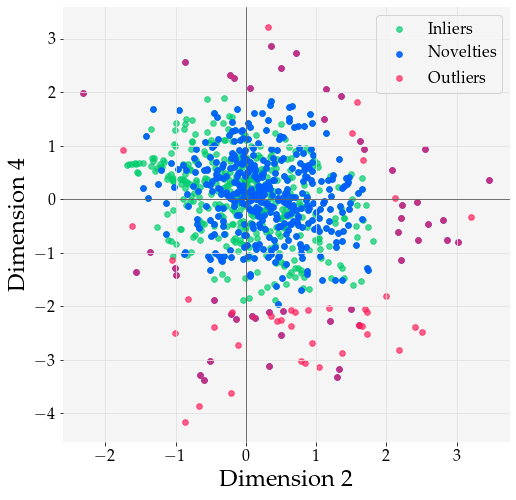

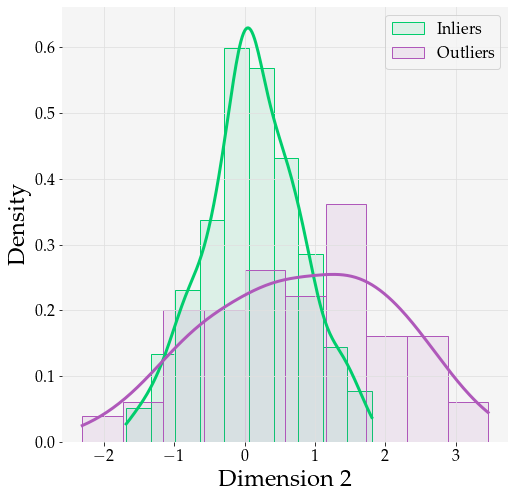

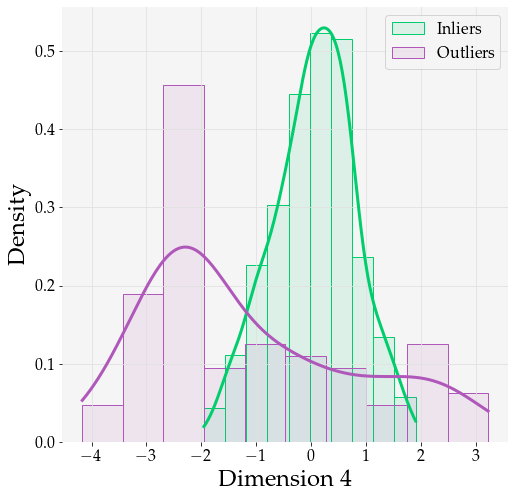

<Figure size 720x720 with 0 Axes>

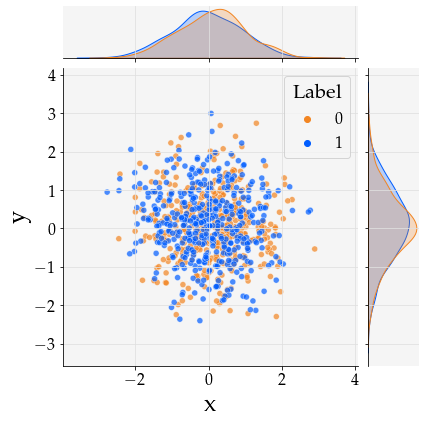

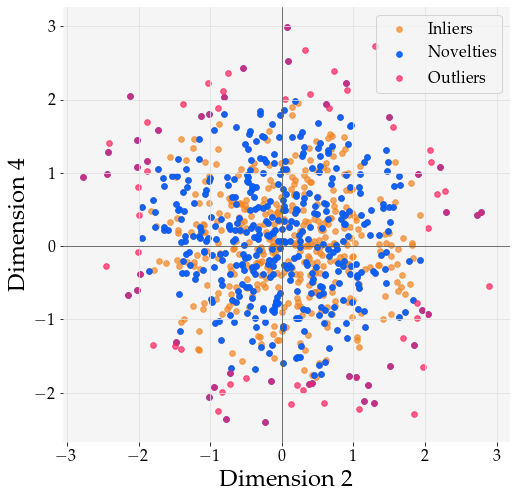

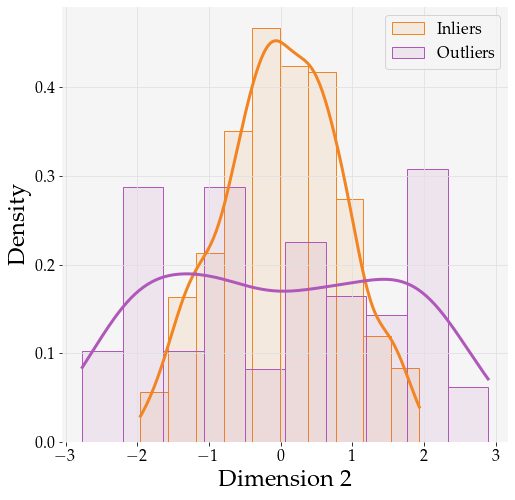

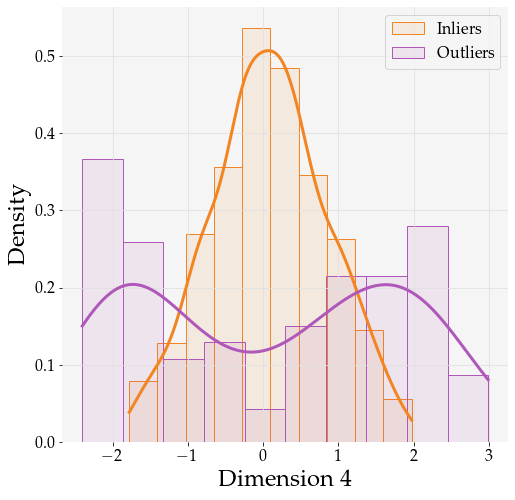

<Figure size 720x720 with 0 Axes>

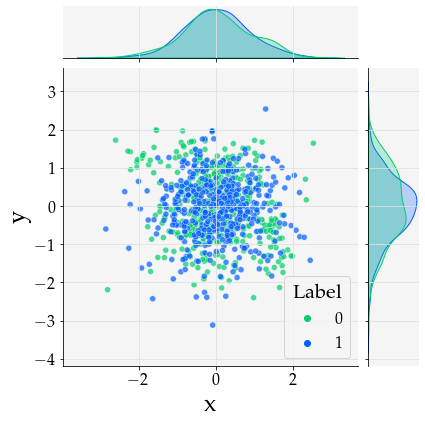

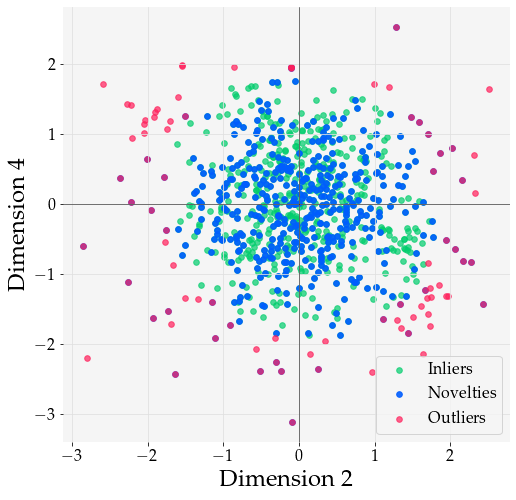

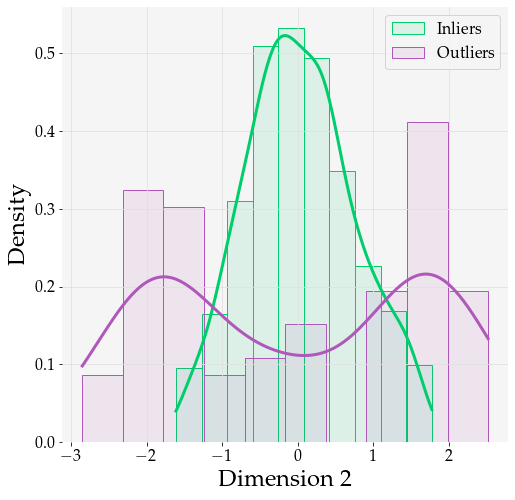

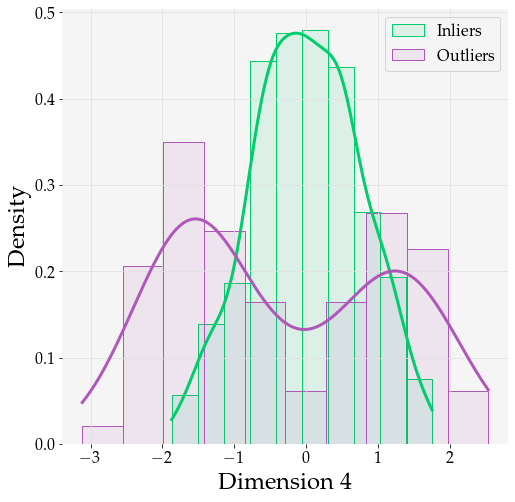

In [44]:
def latent_vis_envelope_2d(latent_vecs, labels, dim_x: int = 2, dim_y: int = 4, save_name=None,
                           stat='density', color='C1'):

    dim_x = 2
    dim_y = 4
    cov_2d = EllipticEnvelope(random_state=49).fit(latent_vecs[:, [dim_x, dim_y]])
    pred_2d = cov_2d.predict(latent_vecs[:, [dim_x, dim_y]])

    inliers_2d = ((pred_2d + 1) // 2).astype(bool)
    outliers_2d = ~inliers_2d
    
    # Setup some long form data
    dat = pd.DataFrame.from_dict({
        'Label': np.array(labels),
        'x': latent_vecs[:, dim_x],
        'y': latent_vecs[:, dim_y]
    })
    
    plt.figure(figsize=(10, 10))
    sns.jointplot(data=dat, x='x', y='y', hue='Label', kind='scatter', palette=[color, 'C5'], alpha=0.7)
    plt.savefig(f'JointPlotScatter-{sn}.pdf', format='pdf', bbox_inches='tight')
    plt.show()
    
    # Plot the 2d results
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.scatter(latent_vecs[inliers_2d, dim_x], latent_vecs[inliers_2d, dim_y], s=2**5, 
               label='Inliers', color=color, alpha=0.7)
    # Novelies plotted here
    ax.scatter(latent_vecs[np.array(labels).astype(bool), dim_x], latent_vecs[np.array(labels).astype(bool), dim_y],
               s=2**5, label='Novelties', color='C5', alpha=0.9)  # This line is for seeing the distr. of novelties
    ax.scatter(latent_vecs[outliers_2d, dim_x], latent_vecs[outliers_2d, dim_y], s=2**5,
               label='Outliers', color='C0', alpha=0.7)

    
    ax.axhline(0, 0, c='k', lw=0.5)
    ax.axvline(0, 0, c='k', lw=0.5)
    ax.set_xlabel(f'Dimension {dim_x}')
    ax.set_ylabel(f'Dimension {dim_y}')
    ax.legend()
    if save_name is not None and isinstance(save_name, str):
        plt.savefig(f'2dOutliers-{save_name}.pdf', format='pdf',  bbox_inches='tight')
    plt.show()

    # Plot x dimension
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.histplot(data=latent_vecs[inliers_2d, dim_x], bins=10, alpha=0.1, stat=stat, 
                 kde=True, color=color, edgecolor=color, label='Inliers')
    sns.histplot(data=latent_vecs[outliers_2d, dim_x], bins=10, alpha=0.1, stat=stat,
                 kde=True, color='C3', edgecolor='C3', label='Outliers')
    
    ax.set_xlabel(f'Dimension {dim_x}')
    ax.legend()
    if save_name is not None and isinstance(save_name, str):
        plt.savefig(f'InlierOutlierDensityX-{save_name}.pdf', format='pdf',  bbox_inches='tight')
    plt.show()

    # Plot y dimension
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.histplot(data=latent_vecs[inliers_2d, dim_y], bins=10, alpha=0.1, stat=stat,
                 kde=True, color=color, edgecolor=color, label='Inliers')
    sns.histplot(data=latent_vecs[outliers_2d, dim_y], bins=10, alpha=0.1, stat=stat, 
                 kde=True, color='C3', edgecolor='C3', label='Outliers')
    ax.set_xlabel(f'Dimension {dim_y}')
    ax.legend()
    if save_name is not None and isinstance(save_name, str):
        plt.savefig(f'InlierOutlierDensityY-{save_name}.pdf', format='pdf',  bbox_inches='tight')
    plt.show()
    
    # Here, the negative mahalanobis distance is used as the novelty score
    return -cov_2d.mahalanobis(latent_vecs[:, [dim_x, dim_y]])

# Use the negative Mahalanobis distance as the novelty score
latent_scores_catalog = {}

for sn, res in result_catalog.items():
    lt_vecs = np.stack(res['latent_vecs'], axis=0)
    labels = res['labels']
    color = 'C1' if 'AAE' in sn else 'C6'
    scores_2d = latent_vis_envelope_2d(lt_vecs, labels, save_name=sn, color=color)
    latent_scores_catalog[f'{sn}-2d'] = scores_2d

2021-05-21 08:29:42,934 - DEBUG - STREAM b'IHDR' 16 13
2021-05-21 08:29:42,935 - DEBUG - STREAM b'PLTE' 41 42
2021-05-21 08:29:42,935 - DEBUG - STREAM b'tRNS' 95 13
2021-05-21 08:29:42,935 - DEBUG - STREAM b'pHYs' 120 9
2021-05-21 08:29:42,936 - DEBUG - STREAM b'IDAT' 141 55
2021-05-21 08:29:42,940 - DEBUG - STREAM b'IHDR' 16 13
2021-05-21 08:29:42,940 - DEBUG - STREAM b'PLTE' 41 48
2021-05-21 08:29:42,940 - DEBUG - STREAM b'tRNS' 101 15
2021-05-21 08:29:42,941 - DEBUG - STREAM b'pHYs' 128 9
2021-05-21 08:29:42,941 - DEBUG - STREAM b'IDAT' 149 109
2021-05-21 08:29:42,955 - DEBUG - STREAM b'IHDR' 16 13
2021-05-21 08:29:42,956 - DEBUG - STREAM b'PLTE' 41 48
2021-05-21 08:29:42,956 - DEBUG - STREAM b'tRNS' 101 15
2021-05-21 08:29:42,956 - DEBUG - STREAM b'pHYs' 128 9
2021-05-21 08:29:42,957 - DEBUG - STREAM b'IDAT' 149 518
2021-05-21 08:29:42,967 - DEBUG - STREAM b'IHDR' 16 13
2021-05-21 08:29:42,968 - DEBUG - STREAM b'PLTE' 41 48
2021-05-21 08:29:42,968 - DEBUG - STREAM b'tRNS' 101 15
20

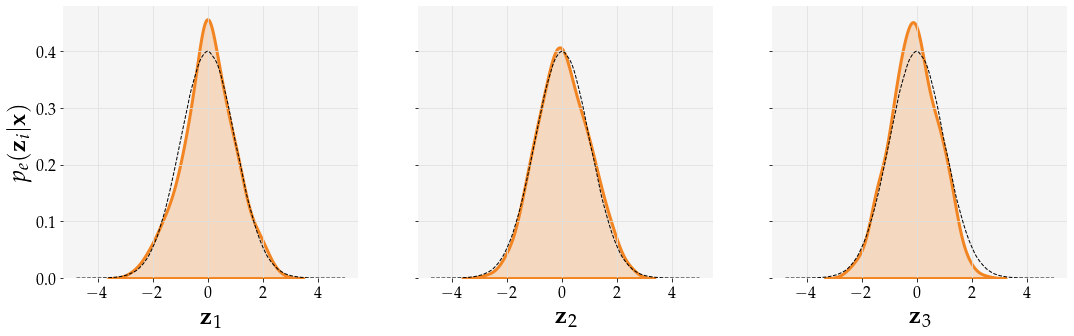

2021-05-21 08:29:54,983 - DEBUG - STREAM b'IHDR' 16 13
2021-05-21 08:29:54,984 - DEBUG - STREAM b'PLTE' 41 48
2021-05-21 08:29:54,984 - DEBUG - STREAM b'tRNS' 101 15
2021-05-21 08:29:54,984 - DEBUG - STREAM b'pHYs' 128 9
2021-05-21 08:29:54,985 - DEBUG - STREAM b'IDAT' 149 144
2021-05-21 08:29:54,987 - DEBUG - STREAM b'IHDR' 16 13
2021-05-21 08:29:54,987 - DEBUG - STREAM b'PLTE' 41 48
2021-05-21 08:29:54,988 - DEBUG - STREAM b'tRNS' 101 15
2021-05-21 08:29:54,988 - DEBUG - STREAM b'pHYs' 128 9
2021-05-21 08:29:54,988 - DEBUG - STREAM b'IDAT' 149 136
2021-05-21 08:29:54,991 - DEBUG - STREAM b'IHDR' 16 13
2021-05-21 08:29:54,991 - DEBUG - STREAM b'PLTE' 41 48
2021-05-21 08:29:54,992 - DEBUG - STREAM b'tRNS' 101 15
2021-05-21 08:29:54,992 - DEBUG - STREAM b'pHYs' 128 9
2021-05-21 08:29:54,992 - DEBUG - STREAM b'IDAT' 149 123
2021-05-21 08:29:54,994 - DEBUG - STREAM b'IHDR' 16 13
2021-05-21 08:29:54,995 - DEBUG - STREAM b'PLTE' 41 48
2021-05-21 08:29:54,995 - DEBUG - STREAM b'tRNS' 101 15


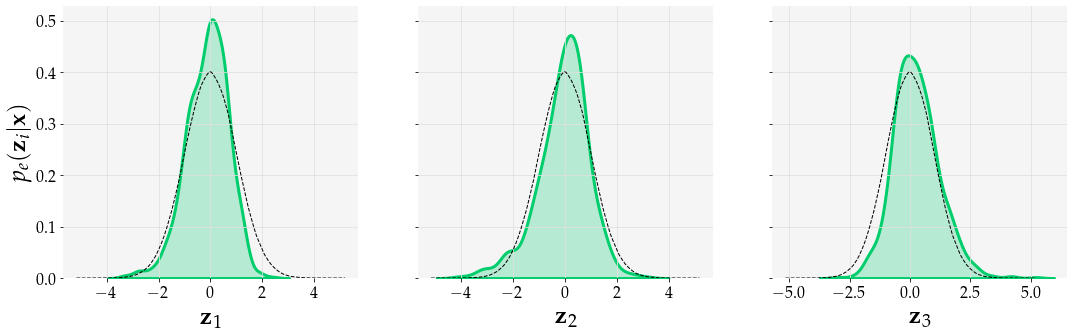

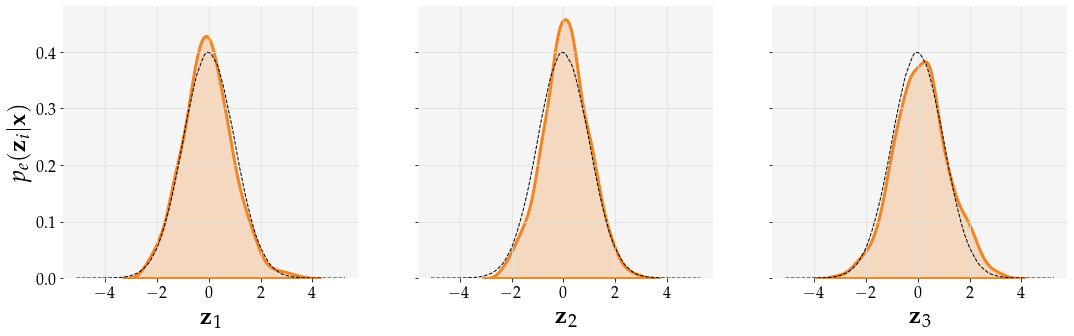

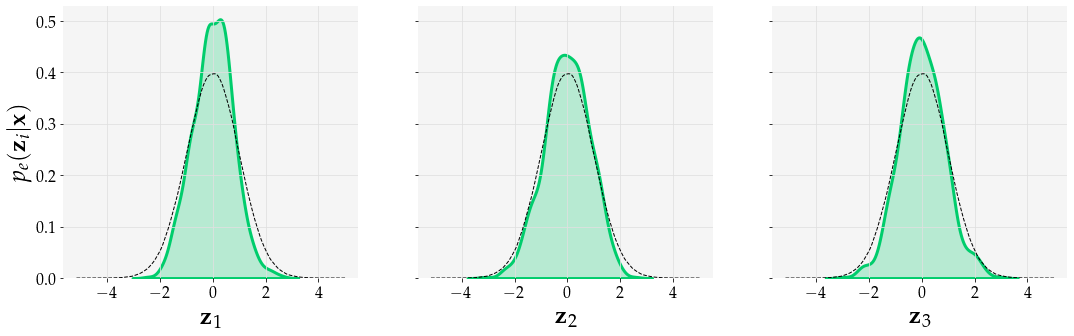

In [7]:
def latent_vis_envelope_nd(latent_vecs, dim_x: int = 2, dim_y: int = 4, save_name=None, color='C1'):

    cov = EllipticEnvelope(random_state=49).fit(latent_vecs)

    pred = cov.predict(latent_vecs)
    standard_normal = np.random.normal(0., 1., 1000000)

    inliers = ((pred + 1) // 2).astype(bool)
    outliers = ~inliers

    fig, ax = plt.subplots(1, 3, sharey=True, figsize=(18,5))
    sns.kdeplot(ax=ax[0], data=standard_normal, color='k', lw=1, ls='--')
    sns.kdeplot(ax=ax[0], data=latent_vecs[:, 3], fill=True, lw=3, color=color)
    ax[0].set_ylabel('$p_{e}(\\mathbf{z}_i|\\mathbf{x})$')
    ax[0].set_xlabel('$\\mathbf{z}_1$')
    
    sns.kdeplot(ax=ax[1], data=standard_normal, color='k', lw=1, ls='--')
    sns.kdeplot(ax=ax[1], data=latent_vecs[:, 4], fill=True, lw=3, color=color)
    ax[1].set_xlabel('$\\mathbf{z}_2$')
    
    sns.kdeplot(ax=ax[2], data=standard_normal, color='k', lw=1, ls='--')
    sns.kdeplot(ax=ax[2], data=latent_vecs[:, 5], fill=True, lw=3, color=color)
    ax[2].set_xlabel('$\\mathbf{z}_3$')
    plt.savefig(f'LatentSpaceProfiles-{save_name}.pdf', format='pdf', bbox_inches='tight')
    plt.show()
    
    # Here, the negative mahalanobis distance is used as the novelty score
    return -cov.mahalanobis(latent_vecs)
    
for sn, res in result_catalog.items():
    lt_vecs = np.stack(res['latent_vecs'], axis=0)
    color = 'C1' if 'AAE' in sn else 'C6'
    scores_nd = latent_vis_envelope_nd(lt_vecs, save_name=sn, color=color)
    latent_scores_catalog[f'{sn}-nd'] = scores_nd

2021-05-21 08:30:18,545 - WARNING - findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
2021-05-21 08:30:18,736 - DEBUG - STREAM b'IHDR' 16 13
2021-05-21 08:30:18,737 - DEBUG - STREAM b'PLTE' 41 48
2021-05-21 08:30:18,737 - DEBUG - STREAM b'tRNS' 101 15
2021-05-21 08:30:18,738 - DEBUG - STREAM b'pHYs' 128 9
2021-05-21 08:30:18,738 - DEBUG - STREAM b'IDAT' 149 128
2021-05-21 08:30:18,740 - DEBUG - STREAM b'IHDR' 16 13
2021-05-21 08:30:18,740 - DEBUG - STREAM b'PLTE' 41 48
2021-05-21 08:30:18,741 - DEBUG - STREAM b'tRNS' 101 15
2021-05-21 08:30:18,741 - DEBUG - STREAM b'pHYs' 128 9
2021-05-21 08:30:18,741 - DEBUG - STREAM b'IDAT' 149 97
2021-05-21 08:30:18,745 - DEBUG - STREAM b'IHDR' 16 13
2021-05-21 08:30:18,745 - DEBUG - STREAM b'PLTE' 41 48
2021-05-21 08:30:18,746 - DEBUG - STREAM b'tRNS' 101 15
2021-05-21 08:30:18,746 - DEBUG - STREAM b'pHYs' 128 9
2021-05-21 08:30:18,746 - DEBUG - STREAM b'IDAT' 149 229
2021-05-21 08:30:18,760 - DEBUG - STREAM b'IHDR' 16 13
2021

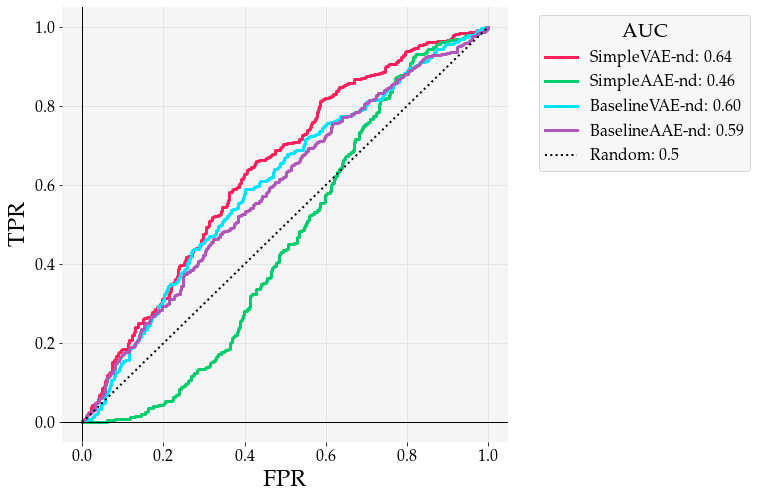

In [8]:
fig, ax = plt.subplots(figsize=(8, 8))

for sn in result_catalog:
    for suf in ['nd']:
        scores = latent_scores_catalog[f'{sn}-{suf}']
        fpr, tpr, thresholds, auc = metrics.roc(scores, result_catalog[sn]['labels'])

        ax.plot(fpr, tpr, label=f'{sn.split("-")[0]}-{suf}: {auc:.2f}')
    

ax.plot([0., 1.], [0., 1.], 'k:', lw=2, label='Random: 0.5')
ax.legend(title='AUC', bbox_to_anchor=(1.05, 1.), loc='upper left')

ax.axhline(0, 0, c='k', lw=1)
ax.axvline(0, 0, c='k', lw=1)

ax.set_xlabel('FPR')
ax.set_ylabel('TPR')

plt.savefig('ROC-latentspace_NoveltyMNIST.pdf', format='pdf', bbox_inches='tight')
plt.show()

2021-05-21 08:30:19,135 - DEBUG - STREAM b'IHDR' 16 13
2021-05-21 08:30:19,135 - DEBUG - STREAM b'PLTE' 41 48
2021-05-21 08:30:19,135 - DEBUG - STREAM b'tRNS' 101 15
2021-05-21 08:30:19,136 - DEBUG - STREAM b'pHYs' 128 9
2021-05-21 08:30:19,136 - DEBUG - STREAM b'IDAT' 149 403
2021-05-21 08:30:19,139 - DEBUG - STREAM b'IHDR' 16 13
2021-05-21 08:30:19,139 - DEBUG - STREAM b'PLTE' 41 48
2021-05-21 08:30:19,139 - DEBUG - STREAM b'tRNS' 101 15
2021-05-21 08:30:19,140 - DEBUG - STREAM b'pHYs' 128 9
2021-05-21 08:30:19,140 - DEBUG - STREAM b'IDAT' 149 156
2021-05-21 08:30:19,142 - DEBUG - STREAM b'IHDR' 16 13
2021-05-21 08:30:19,143 - DEBUG - STREAM b'PLTE' 41 48
2021-05-21 08:30:19,143 - DEBUG - STREAM b'tRNS' 101 15
2021-05-21 08:30:19,143 - DEBUG - STREAM b'pHYs' 128 9
2021-05-21 08:30:19,144 - DEBUG - STREAM b'IDAT' 149 109
2021-05-21 08:30:19,157 - DEBUG - STREAM b'IHDR' 16 13
2021-05-21 08:30:19,158 - DEBUG - STREAM b'PLTE' 41 48
2021-05-21 08:30:19,158 - DEBUG - STREAM b'tRNS' 101 15


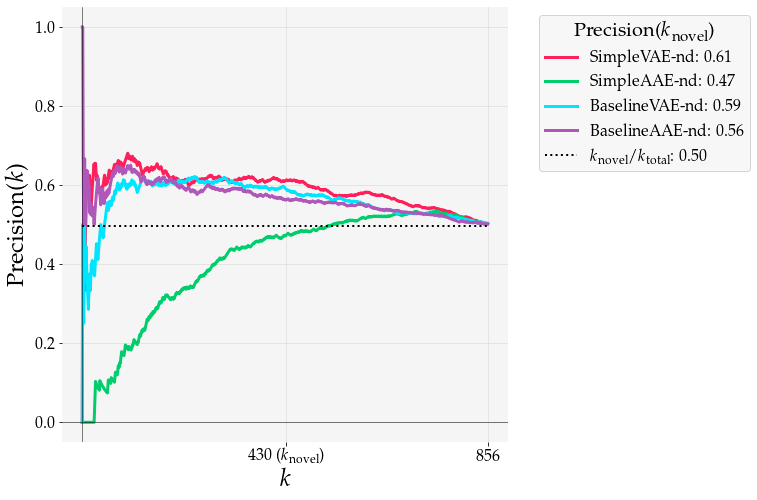

In [9]:
fig, ax = plt.subplots(figsize=(8, 8))

for sn in result_catalog:
    for suf in ['nd']:
        scores = latent_scores_catalog[f'{sn}-{suf}']


        pak = metrics.precision_at_k(scores, result_catalog[sn]['labels'])

        uniques, counts = np.unique(result_catalog[sn]['labels'], return_counts=True)
        random = counts.min() / counts.sum()

        ax.plot(pak, label=f'{sn.split("-")[0]}-{suf}: {pak[int(sum(result_catalog[sn]["labels"]))]:.2f}')
    
ax.plot([0, len(pak)], [random, random], 'k:', lw=2, 
        label='$k_{\mathrm{novel}}/k_{\mathrm{total}}$: '+f'{counts[1]/counts.sum():.2f}')

ax.set_xlabel('$k$')
ax.set_ylabel('Precision($k$)')
ax.legend(title='Precision($k_{\mathrm{novel}}$)', bbox_to_anchor=(1.05, 1.), loc='upper left')

ax.set_xticks([counts[1], counts.sum()])
ax.set_xticklabels([str(counts[1])+' ($k_{\mathrm{novel}}$)', counts.sum()])

# Draw axes for styling
ax.axhline(0, 0, c='k', lw=0.5)
ax.axvline(0, 0, c='k', lw=0.5)

plt.savefig('Pak-latentspace_NoveltyMNIST.pdf', format='pdf', bbox_inches='tight')
plt.show()

SimpleVAE-v1


2021-05-21 08:30:19,547 - DEBUG - STREAM b'IHDR' 16 13
2021-05-21 08:30:19,547 - DEBUG - STREAM b'PLTE' 41 48
2021-05-21 08:30:19,547 - DEBUG - STREAM b'tRNS' 101 15
2021-05-21 08:30:19,548 - DEBUG - STREAM b'pHYs' 128 9
2021-05-21 08:30:19,548 - DEBUG - STREAM b'IDAT' 149 953
2021-05-21 08:30:19,559 - DEBUG - STREAM b'IHDR' 16 13
2021-05-21 08:30:19,559 - DEBUG - STREAM b'PLTE' 41 48
2021-05-21 08:30:19,560 - DEBUG - STREAM b'tRNS' 101 15
2021-05-21 08:30:19,560 - DEBUG - STREAM b'pHYs' 128 9
2021-05-21 08:30:19,561 - DEBUG - STREAM b'IDAT' 149 93
2021-05-21 08:30:19,563 - DEBUG - STREAM b'IHDR' 16 13
2021-05-21 08:30:19,563 - DEBUG - STREAM b'PLTE' 41 48
2021-05-21 08:30:19,563 - DEBUG - STREAM b'tRNS' 101 15
2021-05-21 08:30:19,564 - DEBUG - STREAM b'pHYs' 128 9
2021-05-21 08:30:19,564 - DEBUG - STREAM b'IDAT' 149 112
2021-05-21 08:30:19,566 - DEBUG - STREAM b'IHDR' 16 13
2021-05-21 08:30:19,566 - DEBUG - STREAM b'PLTE' 41 48
2021-05-21 08:30:19,566 - DEBUG - STREAM b'tRNS' 101 15
2

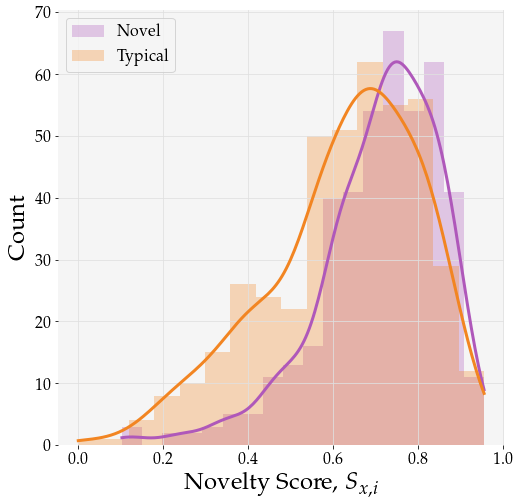

SimpleAAE-v3


2021-05-21 08:30:20,031 - DEBUG - STREAM b'IHDR' 16 13
2021-05-21 08:30:20,032 - DEBUG - STREAM b'PLTE' 41 48
2021-05-21 08:30:20,032 - DEBUG - STREAM b'tRNS' 101 15
2021-05-21 08:30:20,032 - DEBUG - STREAM b'pHYs' 128 9
2021-05-21 08:30:20,033 - DEBUG - STREAM b'IDAT' 149 111
2021-05-21 08:30:20,035 - DEBUG - STREAM b'IHDR' 16 13
2021-05-21 08:30:20,035 - DEBUG - STREAM b'PLTE' 41 48
2021-05-21 08:30:20,036 - DEBUG - STREAM b'tRNS' 101 15
2021-05-21 08:30:20,036 - DEBUG - STREAM b'pHYs' 128 9
2021-05-21 08:30:20,036 - DEBUG - STREAM b'IDAT' 149 111
2021-05-21 08:30:20,038 - DEBUG - STREAM b'IHDR' 16 13
2021-05-21 08:30:20,039 - DEBUG - STREAM b'PLTE' 41 48
2021-05-21 08:30:20,039 - DEBUG - STREAM b'tRNS' 101 15
2021-05-21 08:30:20,039 - DEBUG - STREAM b'pHYs' 128 9
2021-05-21 08:30:20,040 - DEBUG - STREAM b'IDAT' 149 135
2021-05-21 08:30:20,041 - DEBUG - STREAM b'IHDR' 16 13
2021-05-21 08:30:20,042 - DEBUG - STREAM b'PLTE' 41 48
2021-05-21 08:30:20,042 - DEBUG - STREAM b'tRNS' 101 15


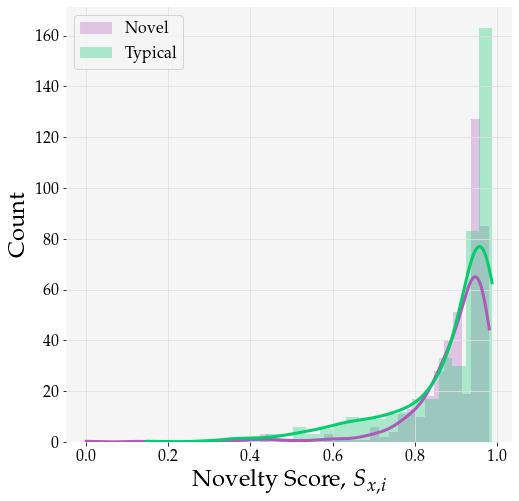

BaselineVAE-v1


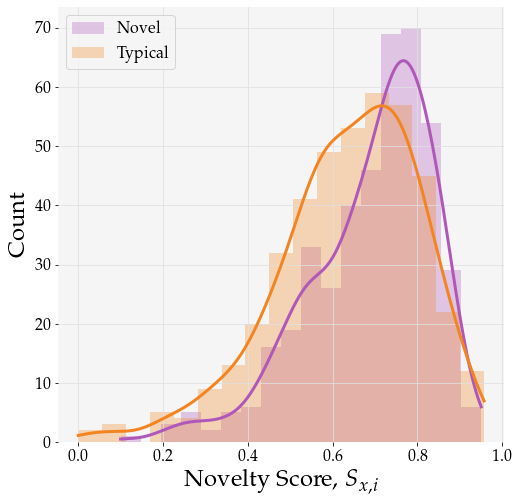

BaselineAAE-v2


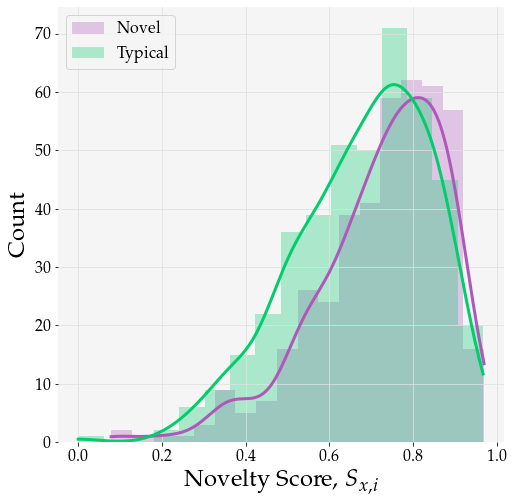

In [10]:
def score_density_vis(lt_scores, rc_scores, labels, sn, color='C1'):
    
    labels = np.array(labels).astype(bool)
    lt_scores = np.array(lt_scores)
    
    # Scale novelty scores between 0,1, though it doesn't really matter
    lt_scores /= np.max(np.abs(lt_scores))
    lt_scores += 1
    rc_scores = np.array(rc_scores)
    
#     fig, ax = plt.subplots(figsize=(8, 8))
#     sns.histplot(data=rc_scores[labels], label='Novel', color='C3', fill=True, lw=0, alpha=0.3, kde=True)
#     sns.histplot(data=rc_scores[~labels], label='Typical', color=color, fill=True, lw=0, alpha=0.3, kde=True)
# #     sns.kdeplot(data=rc_scores[labels], label='Novel', color='C3', fill=True, lw=3)
# #     sns.kdeplot(data=rc_scores[~labels], label='Typical', color=color, fill=True, lw=3)
#     ax.set_xlabel('Novelty Score, $S_{x,i}$')
#     plt.legend()
#     plt.savefig(f'ReconstructionScoreDensity-{sn}-CuriosityMastcam.pdf', format='pdf', bbox_inches='tight')
#     plt.show()
    
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.histplot(data=lt_scores[labels], label='Novel', color='C3', fill=True, lw=0, alpha=0.3, kde=True)
    sns.histplot(data=lt_scores[~labels], label='Typical', color=color, fill=True, lw=0, alpha=0.3, kde=True)
#     sns.kdeplot(data=lt_scores[labels], label='Novel', color='C3', fill=True, common_norm=True, lw=3)
#     sns.kdeplot(data=lt_scores[~labels], label='Typical', color=color, fill=True, common_norm=True, lw=3)
    ax.set_xlabel('Novelty Score, $S_{x,i}$')
    plt.legend()
    plt.savefig(f'LatentScoreDensity-{sn}-CuriosityMastcam.pdf', format='pdf', bbox_inches='tight')
    plt.show()

for sn, res in result_catalog.items():
    print(sn)
            
    lt_scores = latent_scores_catalog[f'{sn}-nd']
    rc_scores = res['scores']
    color = 'C1' if 'AAE' in sn else 'C6'
    score_density_vis(lt_scores, rc_scores, res['labels'], sn, color=color)